# Ridge regression on MNIST data and scattering transform features

In this notebook, we give one example on how reproduce the learning curves of ridge regression on real data sets. In this example, we look at the following setting: 
- **Data:** $x^{\mu}\in\mathbb{R}^{28 x 28}$ MNIST digits with labels $y^{\mu}=1$ for even numbers, $y^{\mu}=-1$ for odd numbers. Therefore, $D=28*28 = 784$.
- **Student Feature:** The student features $\varphi_{s}: \mathbb{R}^{D}\to \mathbb{R}^{p}$ is taken to be a Scattering transform with parameters J=3, L=8 (see [arXiv: 1203.1513](https://arxiv.org/abs/1203.1513) for details). 

## Pre-processing data

We will use `pyTorch` just as a convenient way to download data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torch

First, let's define a pre-processing function that centers and normalises data.

In [2]:
def preprocess_data(dataset):
    '''
    Preprocess MNIST data set: 
    center, divide by global variance and assign labels +1 for even, -1 for odd digits.
    
    Args:
        - pyTorch dataset
    
    Return:
        - tuple (X,y) where both X and y are numpy arrays.
    '''
    n_samples, _, _ = dataset.data.shape
    X = torch.clone(dataset.data).float()
    y = torch.clone(dataset.targets).view(n_samples,).float()
    
    data, labels = [], []
    # Extract digits and create labels
    for k,label in enumerate(y):
        if label in [0, 2, 4, 6, 8]:
            data.append(X[k].numpy())
            labels.append(1)
        elif label in [1, 3, 5, 7, 9]:
            data.append(X[k].numpy())
            labels.append(-1)
            
    data = np.array(data)
    data -= data.mean(axis=0)
    data /= data.std()

    return np.array(data), np.array(labels)

Now let's download MNIST and apply our pre-processing function. Note that for simplicity here we are using the full MNIST training set as our universe. We could also take the training+test to have more samples.

In [4]:
# Load MNIST 
mnist = datasets.MNIST(root='data', train=True, download=True, transform=None)

# Pre-process
C, y = preprocess_data(mnist)

## Going to feature space

For the scattering transform, we will use the convenient out-of-the-box package `kymatio`, see https://www.kymat.io/ for the documentation.

In [7]:
from kymatio.sklearn import Scattering2D

ntot, dx, dy = C.shape
S = Scattering2D(shape=(dx,dy), J=3, L=8)

We now project our data in feature space by applying the scattering transform, and flatten it. As discussed in the 

In [ ]:
# Data in feature spac
V = S(C).reshape(ntot, -1)

_, d = V.shape

print('Feature space dimension: {}'.format(d))

## Global variables

As discussed in the manuscript, all linear teachers that separate the features are equivalent for ridge regression. Therefore, we can take the teacher features to be the full universe.

In [12]:
# teacher features
p = ntot
gamma = p/d

# l2 regularisation parameter
lamb = 0.01

## Theoretical curves

To get the theoretical learning curves, recall we need to provide:

- Covariances $(\Psi, \Phi, \Omega)$
- Teacher weights $\theta_{0}\in\mathbb{R}^{p}$

However, as discussed in the manuscript, if we assume a linear teacher $y^{\mu} = \theta_{0}^{\top}u^{\mu}$ and we estimate the population covariances from the whole universe:
\begin{align}
\Psi = \frac{1}{n_{tot}}\sum\limits_{\mu=1}^{n_{tot}}u^{\mu}{u^{\mu}}^{\top}, && \Phi = \frac{1}{n_{tot}}\sum\limits_{\mu=1}^{n_{tot}}u^{\mu}{v^{\mu}}^{\top}, && \Omega = \frac{1}{n_{tot}}\sum\limits_{\mu=1}^{n_{tot}}u^{\mu}{u^{\mu}}^{\top}
\end{align}

It is easy to show that we can write:
\begin{align}
\rho = \frac{1}{p}\theta_{0}\Psi \theta_{0} = \frac{1}{n_{tot}}\sum\limits_{\mu=1}^{n_{tot}}(y^{\mu})^2, && \Phi^{\top}\theta_{0} = \frac{1}{n_{tot}}\sum\limits_{\mu=1}^{n_{tot}}y^{\mu}v^{\top}
\end{align}

Since the saddle-point equations only require the quantities $(\rho, \omega_{i}, t_{i})$ (see notebook `how-to.ipynb`), the equation closes only on quantities that depend on the data only.

In [14]:
# Student-student covariance
print('Computing covariances')
Omega = V.T @ V / ntot # student-student

Computing covariances


In [17]:
print('Computing rho')
rho = y.dot(y) / ntot

print('Diagonalising the student-student covariance')
spec_Omega, U = np.linalg.eigh(Omega)

print('Projecting teacher-student correlation on student-student basis')
diagUtPhiPhitU = np.diag(1/ntot * U.T @ V.T @ y.reshape(p,1) @ 
                         y.reshape(1,p) @ V @ U)

Computing rho
Diagonalising the student-student covariance
Projecting teacher-student correlation on student-student basis


We now have everything we need to run the saddle-point equations from the `state_evolution` package.

In [22]:
import sys
sys.path.append("..")

from state_evolution.data_models.custom import CustomSpectra
from state_evolution.experiments.learning_curve import CustomExperiment

In [24]:
print('Loading data model')
data_model = CustomSpectra(gamma = gamma,
                           rho = rho, 
                           spec_Omega = spec_Omega, 
                           diagonal_term = diagUtPhiPhitU)

print('Loading experiment')
experiment = CustomExperiment(task = 'ridge_regression', 
                              regularisation = lamb, 
                              data_model = data_model, 
                              tolerance = 1e-7, 
                              damping = 0.5, 
                              verbose = False, 
                              max_steps = 1000)

Loading data model
Loading experiment


In [28]:
sc_range = np.linspace(0.01, 3, 100) # sample complexity range
experiment.learning_curve(alphas = sc_range)

# Getting learning curve as pd.DataFrame
theory = experiment.get_curve()

Now let's check the result out:

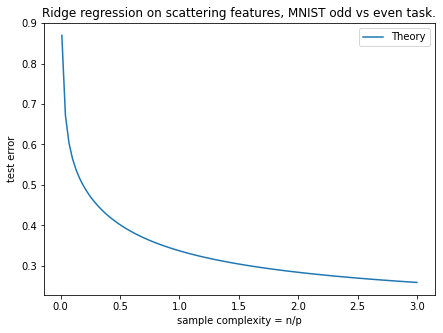

In [32]:
fig, ax = plt.subplots(figsize=(7,5))

plt.title('Ridge regression on scattering features, MNIST odd vs even task.')

theory.plot(x='sample_complexity', y='test_error', style='-', 
              ax=ax, label='Theory')

plt.ylabel(r"test error")
plt.xlabel(r"sample complexity = n/p")

plt.legend()

## Simulations

For conciseness, have wrapped the main simulation modules on a single function `simulate` that takes the full features  matrix $V$. For details, check `simulation.py`

In [33]:
from simulation import simulate

In [34]:
print('Simulating')
sim = simulate(sc_range = np.linspace(0.1, 2.5, 10),
               X = V,
               y = y,
               task = 'regression',
               loss = 'l2',
               lamb = lamb, 
               seeds = 10)

Simulating
Simulating sample complexity: 0.1
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.3666666666666667
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.6333333333333333
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.9
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.1666666666666667
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.4333333333333333
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.7000000000000002
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.9666666666666668
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
See

## Comparing simulations to theory

Finally, let's compare simulation against theory by plotting them together.

In [39]:
sim.head()

,test_error,train_error,test_error_std,train_error_std,lambda,sample_complexity,task,loss
0,0.563790,0.514481,0.004755,0.027235,0.01,0.100000,regression,l2
1,0.432621,0.410876,0.005039,0.017449,0.01,0.366667,regression,l2
2,0.378062,0.366773,0.003487,0.011100,0.01,0.633333,regression,l2
3,0.344247,0.340167,0.002252,0.007724,0.01,0.900000,regression,l2
4,0.325868,0.313892,0.001694,0.010887,0.01,1.166667,regression,l2


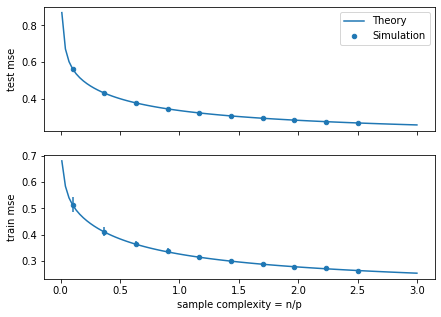

In [46]:
fig, ax = plt.subplots(2,1, figsize=(7,5), sharex=True)

# Test error
theory.plot(x='sample_complexity', 
            y='test_error', 
            style='-', 
            ax=ax[0], 
            label='Theory')

sim.plot(x='sample_complexity', 
         y='test_error', 
         style='.', 
         kind='scatter',
         yerr = 'test_error_std', 
         ax=ax[0], 
         label='Simulation')

theory.plot(x='sample_complexity', 
            y='train_loss', 
            style='-', 
            ax=ax[1], 
            legend=False)

sim.plot(x='sample_complexity', 
         y='train_loss', 
         style='.', 
         kind='scatter',
         yerr = 'train_loss_std', 
         ax=ax[1], 
         legend=False)


ax[0].set_ylabel(r"test mse")
ax[1].set_ylabel(r"train mse")

plt.xlabel(r"sample complexity = n/p")

ax[0].legend()